# TP Deep Clustering


<img src="https://drive.google.com/uc?id=13dN55x2iT_Y29SRkq4748SxaYLfgt_Kp" width="1200">


L'objectif de ce TP consiste à créer un modèle constitué de plusieurs parties :

- Un auto-codeur, pré-entraîné pour apprendre la représentation condensée initiale des jeux de données non étiquetés.
- Une couche de clustering empilée sur l'encodeur pour affecter la sortie de l'encodeur à un cluster. Les poids de la couche de clustering sont initialisés avec les centres de cluster de K-Means basés sur l'évaluation actuelle.
- Entraîner le modèle de clustering pour affiner la couche de clustering et le codeur conjointement.


In [1]:
from time import time
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input, Layer, InputSpec,  Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Chargement des données

In [2]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist # à tester, + complexe que l'ensemble mnist

import numpy as np

# Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST/Fashion mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_trainIm = x_train.astype('float32') / 255.
x_testIm = x_test.astype('float32') / 255.

x_train = np.reshape(x_trainIm, (len(x_train), 784))
x_test = np.reshape(x_testIm, (len(x_test), 784))

# Nombre de classes à trouver
n_clusters=10

# Baseline par clustering classique par kmeans

In [3]:
# nombre de chiffres
n_digits = len(np.unique(y_test))

# Initialisation du Kmeans
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Appliquer Kmeans sur base d'apprentissage
y_pred_kmeans=kmeans.fit_predict(x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
# Score de performance
accuracy_score(y_train, y_pred_kmeans)

0.1898

## Attribution des étiquettes de cluster

La classification K-means est une méthode d'apprentissage automatique non supervisée ; par conséquent, les étiquettes attribuées par notre algorithme KMeans font référence à la classification à laquelle chaque tableau a été attribué, et non à l'entier cible réel. Pour résoudre ce problème, définissons quelques fonctions qui prédiront quel nombre entier correspond à chaque cluster.

In [5]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

In [6]:
def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


In [7]:
# Score de performance sur l'apprentissage après correspondance entre les classes
# A COMPLETER

y_pred_corrected = correspondance(y_pred_kmeans, y_train)
accuracy = accuracy_score(y_train, y_pred_corrected)
print("Accuracy après correspondance des classes:", accuracy)

Accuracy après correspondance des classes: 0.5897833333333333


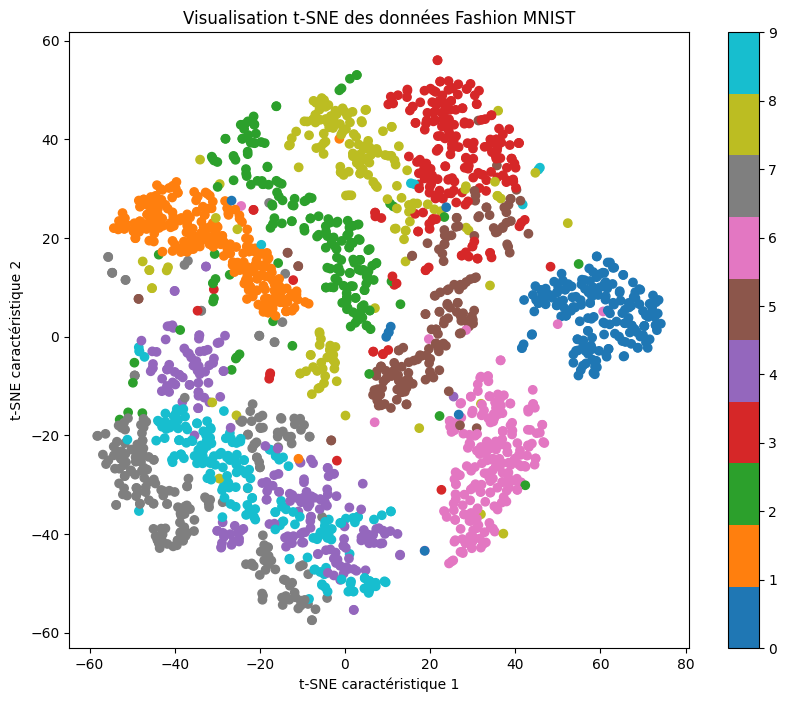

In [12]:
# Affichage des données
count=2000
ListeData = np.random.choice(len(x_test), count)
inputs = x_train[ListeData]
classes = y_train[ListeData]

# Appliquer une réduction de données en 2D via la TSNE
# A COMPLETER
# Réduction en 2D avec t-SNE
tsne = TSNE(n_components=2, random_state=0)
x_2d = tsne.fit_transform(inputs)

# Création du plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=classes, cmap='tab10')
plt.colorbar(scatter)
plt.title('Visualisation t-SNE des données Fashion MNIST')
plt.xlabel('t-SNE caractéristique 1')
plt.ylabel('t-SNE caractéristique 2')
plt.show()

# Autoencodeur classique à définir

In [13]:
# Architecture de l'autoencodeur
# à coder

# Dimension de l'entrée
input_img = Input(shape=(784,))

# Dimension de l'espace latent
latent_dim = 10

# Définition d'un encodeur
x = Dense(500, activation='relu')(input_img)
y = Dense(200, activation='relu')(x)
encoded = Dense(latent_dim, activation='linear')(y)

# Définition d'un decodeur
decoder_input = Input(shape=(latent_dim,))
x = Dense(200, activation='relu')(decoder_input)
y = Dense(500, activation='relu')(x)
decoded = Dense(784, activation='sigmoid')(y)

# Construction d'un modèle séparé pour pouvoir accéder aux décodeur et encodeur
encoder = Model(input_img, encoded)
decoder = Model(decoder_input, decoded)

# Construction du modèle de l'auto-encodeur
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)


In [14]:
# Autoencodeur summary
# à coder
autoencoder.compile(optimizer='Adam', loss='BinaryCrossentropy')
autoencoder.summary()
print(encoder.summary())
print(decoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 model (Functional)          (None, 10)                494710    
                                                                 
 model_1 (Functional)        (None, 784)               495484    
                                                                 
Total params: 990194 (3.78 MB)
Trainable params: 990194 (3.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (

# Entraînement de l'autoencodeur

In [15]:
# Entraînement de l'autoencodeur
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
469/469 [==============================] - 23s 46ms/step - loss: 0.1709 - val_loss: 0.1239
Epoch 2/25
469/469 [==============================] - 18s 39ms/step - loss: 0.1193 - val_loss: 0.1137
Epoch 3/25
469/469 [==============================] - 13s 29ms/step - loss: 0.1124 - val_loss: 0.1096
Epoch 4/25
469/469 [==============================] - 13s 28ms/step - loss: 0.1088 - val_loss: 0.1072
Epoch 5/25
469/469 [==============================] - 13s 29ms/step - loss: 0.1065 - val_loss: 0.1056
Epoch 6/25
469/469 [==============================] - 13s 28ms/step - loss: 0.1048 - val_loss: 0.1042
Epoch 7/25
469/469 [==============================] - 14s 30ms/step - loss: 0.1034 - val_loss: 0.1035
Epoch 8/25
469/469 [==============================] - 14s 30ms/step - loss: 0.1023 - val_loss: 0.1027
Epoch 9/25
469/469 [==============================] - 14s 30ms/step - loss: 0.1013 - val_loss: 0.1020
Epoch 10/25
469/469 [==============================] - 16s 33ms/step - loss: 0.100

In [16]:
# Encoder et décoder quelques chiffres de l'ensemble test
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 2s 5ms/step


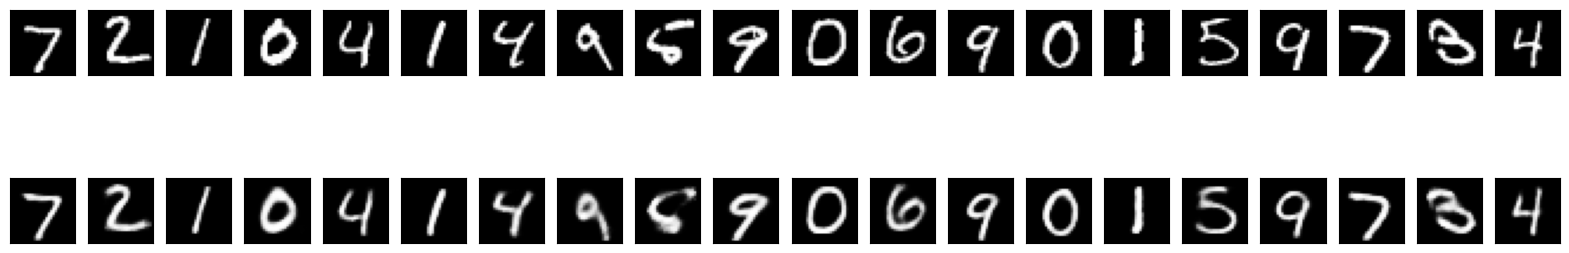

In [17]:
n = 20  # Combien de chiffres nous allons afficher

# Afficher l'image reconstruite à partir de l'espace latent après entraînement
# À COMPLÉTER
plt.figure(figsize=(20, 4))
for i in range(n):
    # Affichage de l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Affichage de l'image reconstruite par l'autoencodeur
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

63/63 [==============================] - 0s 5ms/step


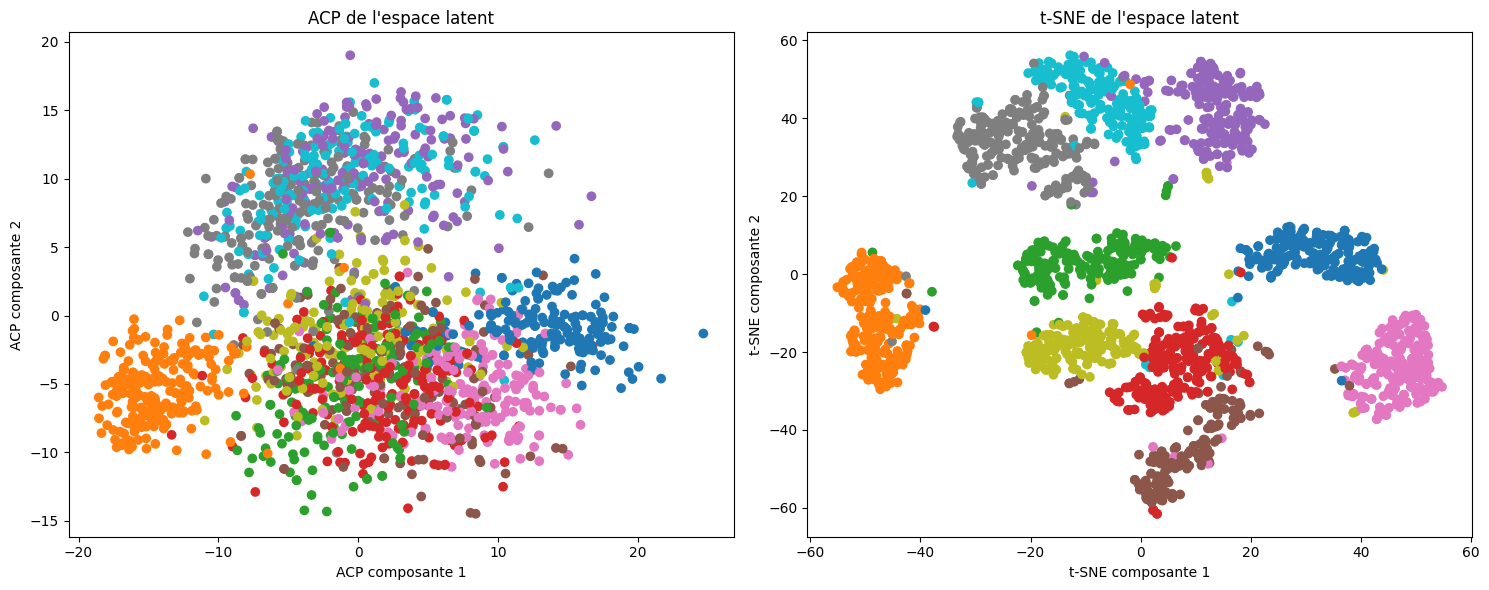

In [31]:
# Affichage de l'espace latent par réduction de dimension
count=2000
inputs = x_train[ListeData]
classes = y_train[ListeData]

# Récupération des données dans l'espace latent
encoded_imgs = encoder.predict(inputs)

# Réduction de dimension 2D par ACP
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_imgs)

# Réduction de dimension 2D par la TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(encoded_imgs)

# Affichage de l'espace latent par ACP et t-SNE côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Affichage de l'espace latent par ACP
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=classes, cmap='tab10')
axes[0].set_title('ACP de l\'espace latent')
axes[0].set_xlabel('ACP composante 1')
axes[0].set_ylabel('ACP composante 2')

# Affichage de l'espace latent par t-SNE
scatter = axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=classes, cmap='tab10')
axes[1].set_title('t-SNE de l\'espace latent')
axes[1].set_xlabel('t-SNE composante 1')
axes[1].set_ylabel('t-SNE composante 2')
plt.tight_layout()
plt.show()



In [21]:
# Classification par kmeans de l'espace latent sur l'ensemble d'apprentissage

# Initialisation du Kmeans
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Affichage
inputsTrain = x_train
classesTrain = y_train

# Kmeans sur base d'apprentissage
kmeans.fit(inputsTrain)
y_pred_kmeans = kmeans.predict(inputsTrain)

# Score de performance sur l'apprentissage
accuracy = accuracy_score(classesTrain, y_pred_kmeans)
print("Performance de l'autoencodeur : Accuracy du KMeans sur l'espace latent =", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Performance de l'autoencodeur : Accuracy du KMeans sur l'espace latent = 0.14906666666666665


## Couche de clustering
maintient les centres de cluster $\mu_j$ comme poids entraînables et projette chaque point intégré $z_i$ en soft label $q_i$ par la distribution $t$ de Student:
$$q_{ij}=\frac{(1+\|z_i-\mu_j\|^2)^{-1}}{\sum_j(1+\|z_i-\mu_j\|^2)^{-1}}$$
où $q_{ij}$ est la $j$ième entrée de $q_i$, représentant la probabilité d'appartenance de $z_i$ au cluster $j$.

In [32]:
class ClusteringLayer(Layer):
    """
    La couche de classification convertit l'échantillon d'entrée (caractéristique) en une étiquette souple, c'est-à-dire un vecteur qui représente la probabilité d'appartenance de l'échantillon à chaque groupe.
    probabilité d'appartenance de l'échantillon à chaque cluster. La probabilité est calculée avec la distribution t de student.
    # Exemple
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters : nombre de clusters.
        weights : liste de tableaux Numpy de forme `(n_clusters, n_features)` qui représente les centres de clusters initiaux.
        alpha : paramètre de la distribution t de Student. La valeur par défaut est 1.0.
    # Forme de l'entrée
        Tenseur 2D avec la forme : `(n_samples, n_features)`.
    # Forme en sortie
        Tenseur 2D avec forme : `(n_samples, n_clusters)`.
    """


    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
      """ Distribution t de student, la même que celle utilisée dans l'algorithme t-SNE.
                 q_ij = 1/(1+dist(x_i, u_j)^2), puis normalisation.
        Arguments :
            inputs : la variable contenant les données, shape=(n_samples, n_features)
        Retourne :
            q : la distribution t de student, ou des étiquettes souples pour chaque échantillon. shape=(n_samples, n_clusters)
        """
      q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
      q **= (self.alpha + 1.0) / 2.0
      q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
      return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Définition de la distribution $P$ cible définie comme
$$p_{ij}=\frac{q_{ij}^2/\sum_i q_{ij}}{\sum_j (q_{ij}^2/\sum_i q_{ij})}.$$
où $p_{ij}$ est la $j$ième entrée de $p_i$ représentant la probabilité d'appartenance de la donnée $i$ la classe $j$

In [35]:
# Calcul de la distribution cible
def target_distribution(q):
    weight = q ** 2 / q.sum(axis=0)
    return (weight.T / weight.sum(axis=1)).T

In [36]:
# Configuration de la couche de clustering
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

model.compile(optimizer="Adam", loss='kld')

# Entrainement du modèle avec la couche de clustering

In [37]:
# paramètres à fixer
loss = 0
index = 0
maxiter =4000
update_interval = 140
batch_size=128
index_array = np.arange(x_train.shape[0])
tol = 0.005 # seuil pour critère d'arrêt

In [39]:
#Initialisation Kmeans
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))

# récupération des centres de clusters
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # mise à jour de la distribution cible p

        # evaluation de la performance du clustering
        y_pred = q.argmax(1)
        if y_train is not None:
            y_pred=correspondance(y_pred,y_train)
            acc = np.round(accuracy_score(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('(Iter , acc)  ',(ite, acc), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = model.train_on_batch(x=x_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0

1875/1875 [==============================] - 14s 8ms/step
(Iter , acc)   (0, 0.80295)  ; loss= 0.07103
(Iter , acc)   (140, 0.80348)  ; loss= 0.07271
(Iter , acc)   (280, 0.80402)  ; loss= 0.0542
(Iter , acc)   (420, 0.80473)  ; loss= 0.05134
(Iter , acc)   (560, 0.80502)  ; loss= 0.0458
delta_label  0.004916666666666666 < tol  0.005
Reached tolerance threshold. Stopping training.


63/63 [==============================] - 0s 5ms/step


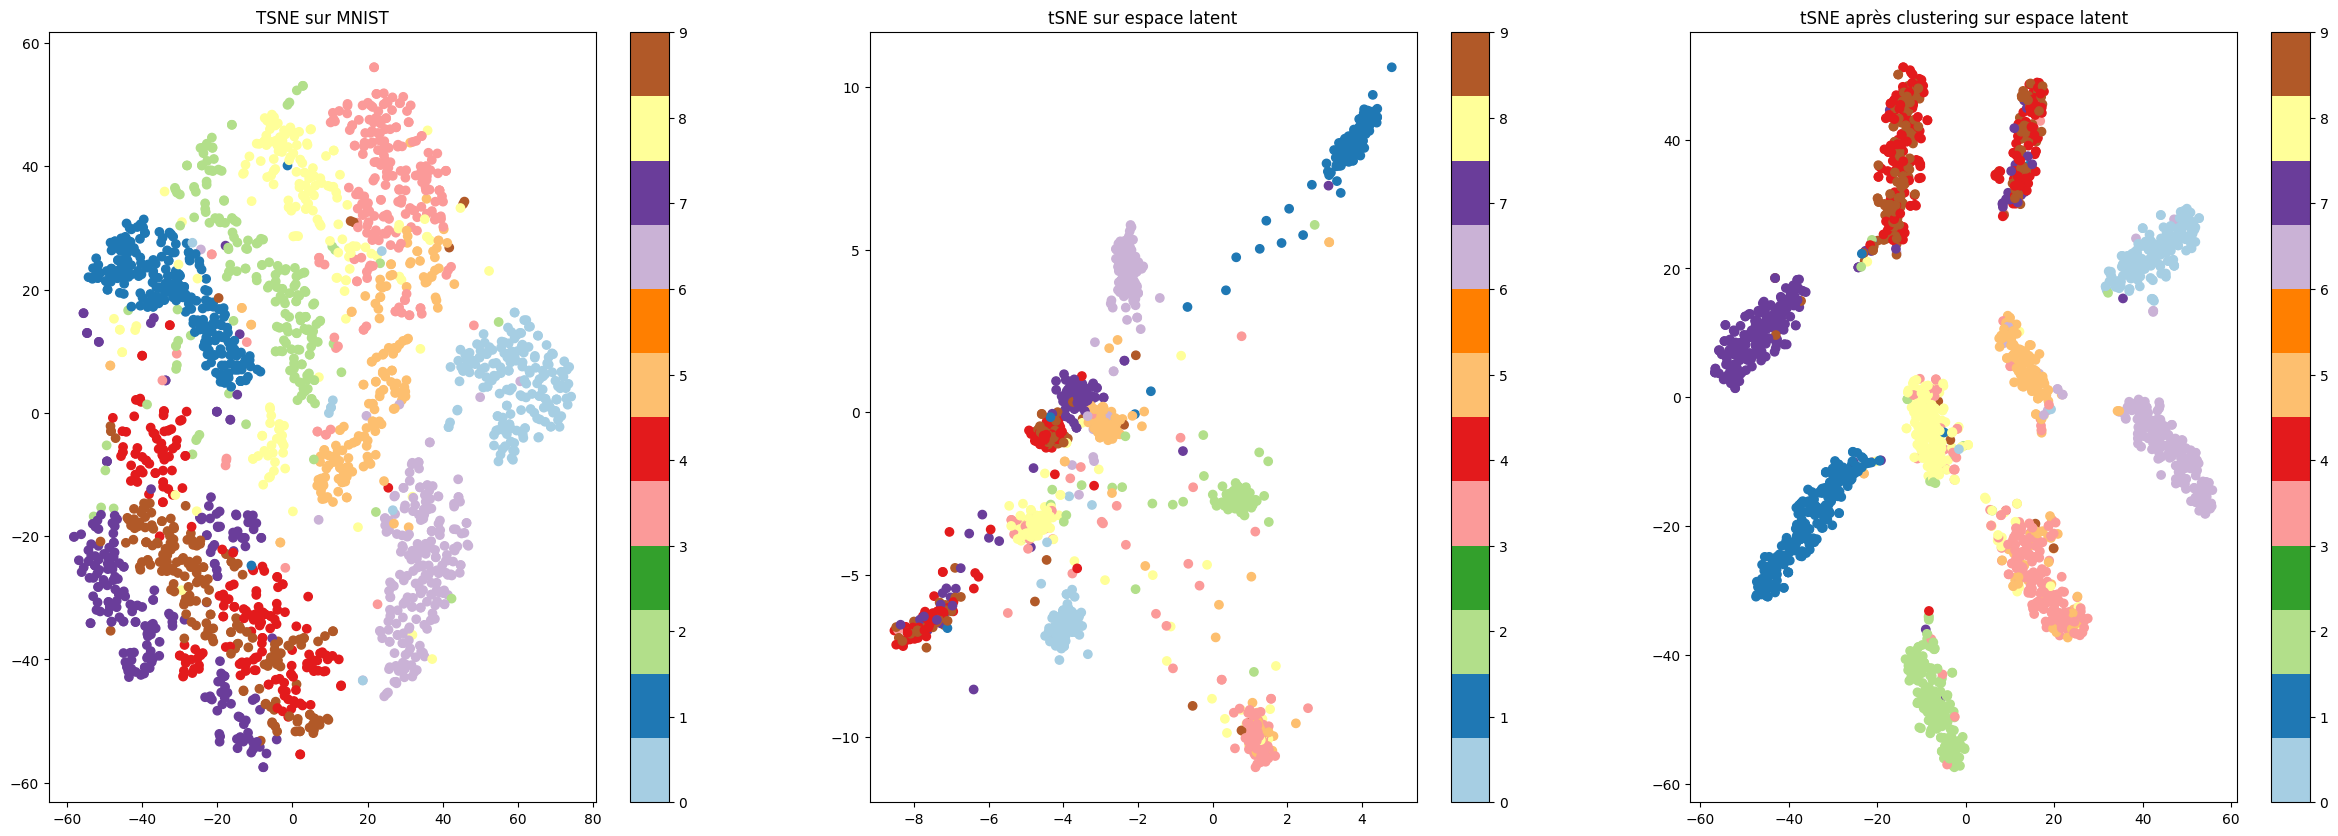

In [42]:
# Affichage de l'impact de cette couche clustering

inputs = x_train[ListeData]
classes = y_train[ListeData]

# TSNE sur espace latent avec kmeans
coordsAC_V2 = encoder.predict(inputs)
coordsTSNE_V2 = TSNE(n_components=2).fit_transform(coordsAC_V2.reshape(count, -1))


fig2= plt.figure(figsize=(30, 10))
ax2=plt.subplot(1,3,1)
ax2.set_title("TSNE sur MNIST")
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=classes,cmap='Paired')
plt.colorbar()


ax2 = plt.subplot(1,3,2)
ax2.set_title("tSNE sur espace latent")
plt.scatter(coordsAC_V2[:, 0], coordsAC_V2[:, 1], c=classes,cmap='Paired')
plt.colorbar()



ax2 = plt.subplot(1,3,3)
ax2.set_title("tSNE après clustering sur espace latent")
plt.scatter(coordsTSNE_V2[:, 0], coordsTSNE_V2[:, 1], c=classes,cmap='Paired')
plt.colorbar()

# Passer à la version convolutive de l'autoencodeur